this is for testing the correctedness of my mcmc algorithm with by brutal forcing a path with only 5 reactions. I will also fix the initial copy number. 

In [18]:
%load_ext line_profiler
import numpy as np
import sys
sys.path.insert(1,'./src/')
from models import ChemicalReactionNetwork
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import corner
from copy import deepcopy
from statsmodels.tsa.stattools import acf
import joblib

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


See [description of this notebook](./questions.md/#july-17th-non-abc)

In [19]:
species = 'A B C'.split()
reactions = [
    ({'A': 1}, {'B': 1}),
    ({'B': 1}, {'A': 1}),
    ({'B': 1}, {'C': 1}),
    ({'C': 1}, {'B': 1}),
]

switch_reaction = {
    0: 3,
    1: 2,
    2: 1,
    3: 0
}

kinetic_rates = np.array([2e-1,1,1,2e-1])
# some of the kinetic rates has to equal. 

model = ChemicalReactionNetwork(reactions, species, kinetic_rates)

X_init = np.array([10,20,30])

T = .06

In [20]:
x,r,t = model.gilespie(X_init,T)
len(r)

3

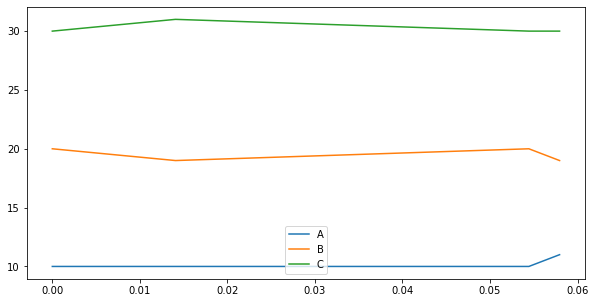

In [21]:
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,x[:,i],label=species[i])
plt.legend();

the observables are only copy number of `B`, so our observation should be that:


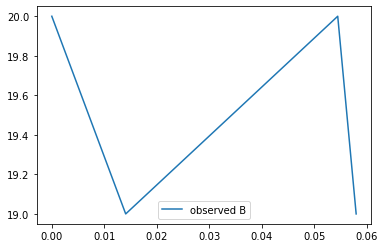

In [22]:
b = model.get_observation(t,x,'B').flatten()
plt.plot(t,b,label='observed B')
plt.legend();

Now, let's think what's in a state:

- reaction time $t_i$
- populations of the 3 species $a_i,b_i,c_i$

So the first step is to generate an initial state based on our observation. 

The observation provides for us the $t_i,a_i$. I will use a random number generator to generate an initial guess of $b_i, c_i$


In [23]:
def get_r(X):
    
    r = np.zeros(len(X[:,0])-1,dtype=int)
    
    diff_a = np.diff(X[:,0],1)
    diff_c = np.diff(X[:,2],1)
    r[diff_a==-1] = 0
    r[diff_a==1] = 1
    r[diff_c==1] = 2
    r[diff_c==-1] = 3
    
    return r

def log_likelihood(state):
    
    k,X = state
    r = get_r(X)
    return model.gilespie_exact_log_likelihood(k,X,r,t,T)
    # should this thing be modified a bit? as it is conditioned on fixing b and fixing t. 
    # No, it is still correct up to a constant. so it won't matter in MCMC. 

In [24]:
total_copy_number = np.sum(x[0])
a0 = x[0,0]

def generate_initial_state(b,t,a0=a0,total_copy_number=total_copy_number):
    cond = True
    while cond:
        
        k = np.random.uniform(0,0.5,len(kinetic_rates)) + kinetic_rates
        # a0 = np.random.randint(0,total_copy_number  - b[0])
        
        diff_b = np.diff(b,1) # this equals to '- diff_a - diff_c'
        diff_a = np.zeros(shape=diff_b.shape,dtype=int)
        
        for i,db in enumerate(diff_b):
            if np.random.uniform() < 0.5:
                diff_a[i] = -db
        
        a = np.cumsum(np.insert(diff_a,0,a0))
        c = total_copy_number - a - b
        if np.any(b<0) or np.any(c<0):
            continue
        else:
            X = np.vstack((a,b,c)).T
            log_l = log_likelihood((k,X))
            cond = (log_l == -np.inf)
    
    X = np.array([a,b,c]).T
    return [k,X], log_l

def generate_good_initial_state(b,t):
    state,log_l = generate_initial_state(b,t)
    for i in range(20):
        new_state,new_log_l = generate_initial_state(b,t)
        if new_log_l > log_l:
            state = new_state
            likelihood = new_log_l
    return state, new_log_l

In [25]:
true_state = (kinetic_rates,x)
log_likelihood(true_state)

1.179393048088434

In [26]:
initial_state, init_log_l = generate_good_initial_state(b,t)
init_log_l

0.7065443996177588

In [27]:
a,b,c = initial_state[1].T

Text(0.5, 1.0, 'initial state')

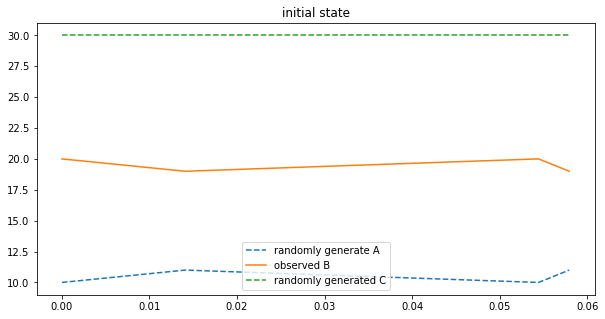

In [28]:
plt.figure(figsize=(10,5))
plt.plot(t,a,'--',label='randomly generate A')
plt.plot(t,b,label='observed B')
plt.plot(t,c, '--', label='randomly generated C')
plt.legend()
plt.title('initial state')

In this particular partial implementation, the only things we can change are 
- kinetic rates
- interchanging reactions 2 and 3. i.e. $B \xLeftrightarrow[k_4]{k_3} C$
- the initial population of the $B,C$

In [29]:
def get_box(k, box_size):

    box = []
    volume = 1

    for t in k:
        lower = max(t-box_size, 0)
        upper = t+box_size
        box.append((lower, upper))
        volume *= (upper-lower)
        
    box = np.array(box).T

    return box, volume

def move_k(state, box_size=min(kinetic_rates)):
    k = state[0].copy()
    X = state[1]
    
    box, volume = get_box(k, box_size)
    new_k = np.random.uniform(*box)

    _, volume2 = get_box(new_k, box_size)

    return (new_k, X), np.log(volume/volume2)


def get_poss(state):
    
    a,b,c = state[1].T
    
    r = np.insert(get_r(state[1]),0,-1)
    a_min = np.minimum.accumulate(a[::-1])[::-1]
    c_min = np.minimum.accumulate(c[::-1])[::-1]
    
    possibilities = list(np.where((a_min > 0) & ((r==1) | (r==3)))[0]) + list(np.where((c_min > 0) & ((r==0) | (r==2)))[0])

    # if a_min[0] > 0 :
        # possibilities.append(0)

    # if c_min[0] > 0 :
        # possibilities.append(-1)
    return np.random.choice(possibilities), r, len(possibilities)

def move_copy_number(state,n_steps=1,log_prob=0):
    '''
    this is merged with moving the initial copy number. 
    '''
    if n_steps == 0:
        return state, 0
    if n_steps == 1:
        
        poss,r,p = get_poss(state)
        k = state[0]
        a,b,c = (state[1].T).copy()
        
        if poss == 0:
            a += -1
            c += 1
        
        elif poss == -1:
            a += 1
            c += -1
        else:
            if r[poss] in [1,3]:
                a[poss:] += -1
                c[poss:] += 1
            else:
                a[poss:] += 1
                c[poss:] += -1
        
        new_X = np.vstack((a,b,c)).T
        new_state = (k,new_X)
        _,_, q = get_poss(new_state)
        return new_state, np.log(p/q) + log_prob
    if n_steps > 1:
        new_state, log_prob = move_copy_number(state,1,log_prob)
        return move_copy_number(new_state,n_steps-1,log_prob)

In [30]:
def mcmc(initial_state, n):

    samples = [initial_state]
    if_accepted = []
    log_likelihoods = [log_likelihood(initial_state)]

    for i in tqdm(range(n), desc='sampling state space'):
        
        if np.random.uniform() < 0.5:
            move = 1
            new_state, log_p = move_copy_number(samples[-1],n_steps=1)
        else:
            move = 2
            new_state, log_p = move_k(samples[-1])
        
        curr_log_pst = log_likelihood(new_state)
            
        log_acceptance = curr_log_pst + log_p - log_likelihoods[-1]
        if log_acceptance >= 0 or np.log(np.random.uniform()) < log_acceptance:
            samples.append(new_state)
            log_likelihoods.append(curr_log_pst)
            if_accepted.append(move)
        else:
            samples.append(samples[-1])
            log_likelihoods.append(log_likelihoods[-1])
            if_accepted.append(0)
    return samples, np.array(if_accepted), np.array(log_likelihoods)

I am going to have a test on the move_state function

In [31]:
pst_samples,if_accepcted, log_likelihoods = mcmc(initial_state, n=int(1e6))

sampling state space:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [32]:
import pickle
with open('pst_samples.pkl','wb') as f:
    pickle.dump(pst_samples,f)
with open('if_accepted.pkl','wb') as f:
    pickle.dump(if_accepcted,f)
with open('log_likelihoods.pkl','wb') as f:
    pickle.dump(log_likelihoods,f)


In [33]:
print('rejection rate:', np.sum(if_accepcted==0)/len(if_accepcted))
print('moving path:', np.sum(if_accepcted==1)/len(if_accepcted))
print('moving kinetic rates:', np.sum(if_accepcted==2)/len(if_accepcted))

rejection rate: 0.332235
moving path: 0.246727
moving kinetic rates: 0.421038


In [34]:
pst_k = np.array([i[0] for i in pst_samples])

In [35]:
with open ('pst_k.pkl','wb') as f:
    pickle.dump(pst_k,f)

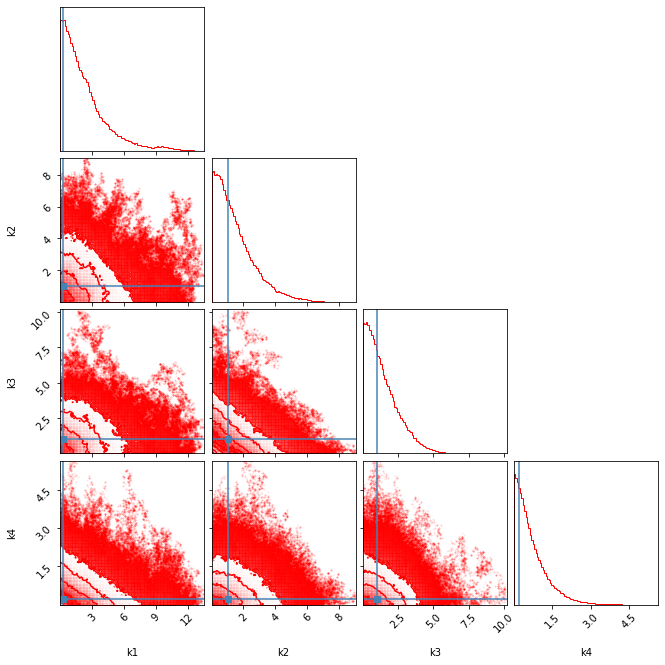

In [36]:
corner.corner(pst_k[10000:], labels=['k1','k2','k3','k4'], truths=true_state[0],smooth=1e-1,bins=100,color='r');

Text(0.5, 1.0, 'autocorrelation of k1')

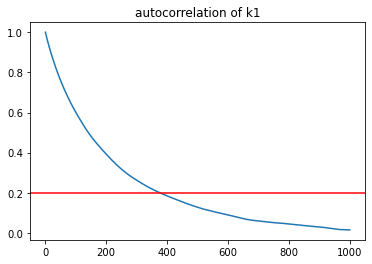

In [57]:
plt.plot(acf(pst_k[2000:,3],nlags=1000))
plt.axhline(0.2, color='r')
plt.title('autocorrelation of k1')

In [38]:
log_likelihood(pst_samples[-1])

-0.5926188010588654

In [39]:
log_likelihood(true_state)

1.179393048088434

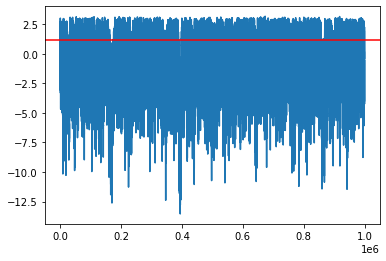

In [40]:
plt.plot(log_likelihoods,label='log likelihoods of MCMC samples')
plt.axhline(log_likelihood(true_state), color='r', label='true state')

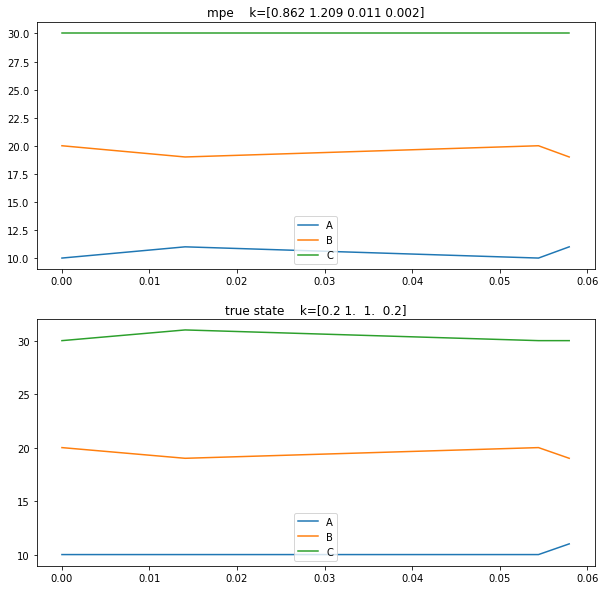

In [41]:
fig, axes = plt.subplots(2,1,figsize=(10,10))

for i in range(3):
    axes[0].plot(t,pst_samples[np.argmax(log_likelihoods)][1][:,i], label=model.index2chemical[i])
    axes[0].set_title('mpe    k=' + str(np.round(pst_samples[np.argmax(log_likelihoods)][0],3)))
    axes[0].legend()
    
    axes[1].plot(t,true_state[1][:,i], label=model.index2chemical[i])
    axes[1].set_title('true state    k=' + str(np.round(true_state[0],3)))
    axes[1].legend()
    

# Brute-Force evaluating the log likelihoods

- generate a grid of $k$ 
- find all the possible full observations, which is just 2

In [42]:
def get_all_path(b,a0=a0):
    
    diff_b = np.diff(b,1) # this equals to '- diff_a - diff_c'
    path = []
    for i in range(2**(len(b)-1)):        
    
        diff_a = np.zeros(shape=diff_b.shape,dtype=int)
        
        for j,db in enumerate(diff_b):
            if (i>>j) % 2 == 0:
                diff_a[j] = -db
        
        a = np.cumsum(np.insert(diff_a,0,a0))
        c = total_copy_number - a - b
        if np.any(b<0) or np.any(c<0):
            continue
        else:
            path.append(np.array((a,b,c)).T)
    return path

In [43]:
paths = get_all_path(b)

In [44]:
kinetic_rates

array([0.2, 1. , 1. , 0.2])

In [45]:
upper_bound = np.quantile(pst_k,q= 0.95, axis=0)
upper_bound

array([6.91964738, 4.06126635, 3.64601787, 1.93810475])

In [46]:
lower_bound = np.quantile(pst_k,q= 0.05, axis=0)
lower_bound

array([0.14997886, 0.10771575, 0.10395395, 0.04331637])

I will use data to make the grid

In [52]:
likelihoods_grid = np.zeros(shape=(50,50,50,50))

In [53]:
k1_grid, k2_grid, k3_grid, k4_grid = [np.linspace(lower_bound[i], upper_bound[i],50) for i in range(4)]

In [54]:
for i1,k1 in tqdm(list(enumerate(k1_grid)), desc='level 1',position=0,leave=True):
    for i2,k2 in tqdm(list(enumerate(k2_grid)), desc='level 2',position=1,leave=True):
        for i3,k3 in enumerate(k3_grid):
            for i4,k4 in enumerate(k4_grid):
                k = np.array((k1,k2,k3,k4))
                likelihoods_grid[i1,i2,i3,i4] = np.sum(np.exp([log_likelihood((k,path)) for path in paths]))/len(paths)    

level 1:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

level 2:   0%|          | 0/50 [00:00<?, ?it/s]

Now, I can use the np.mean to plot the corner plots

In [55]:
grids = [k1_grid, k2_grid, k3_grid, k4_grid]

Text(0.5, 0.98, 'brute forced likelihoods corner plots')

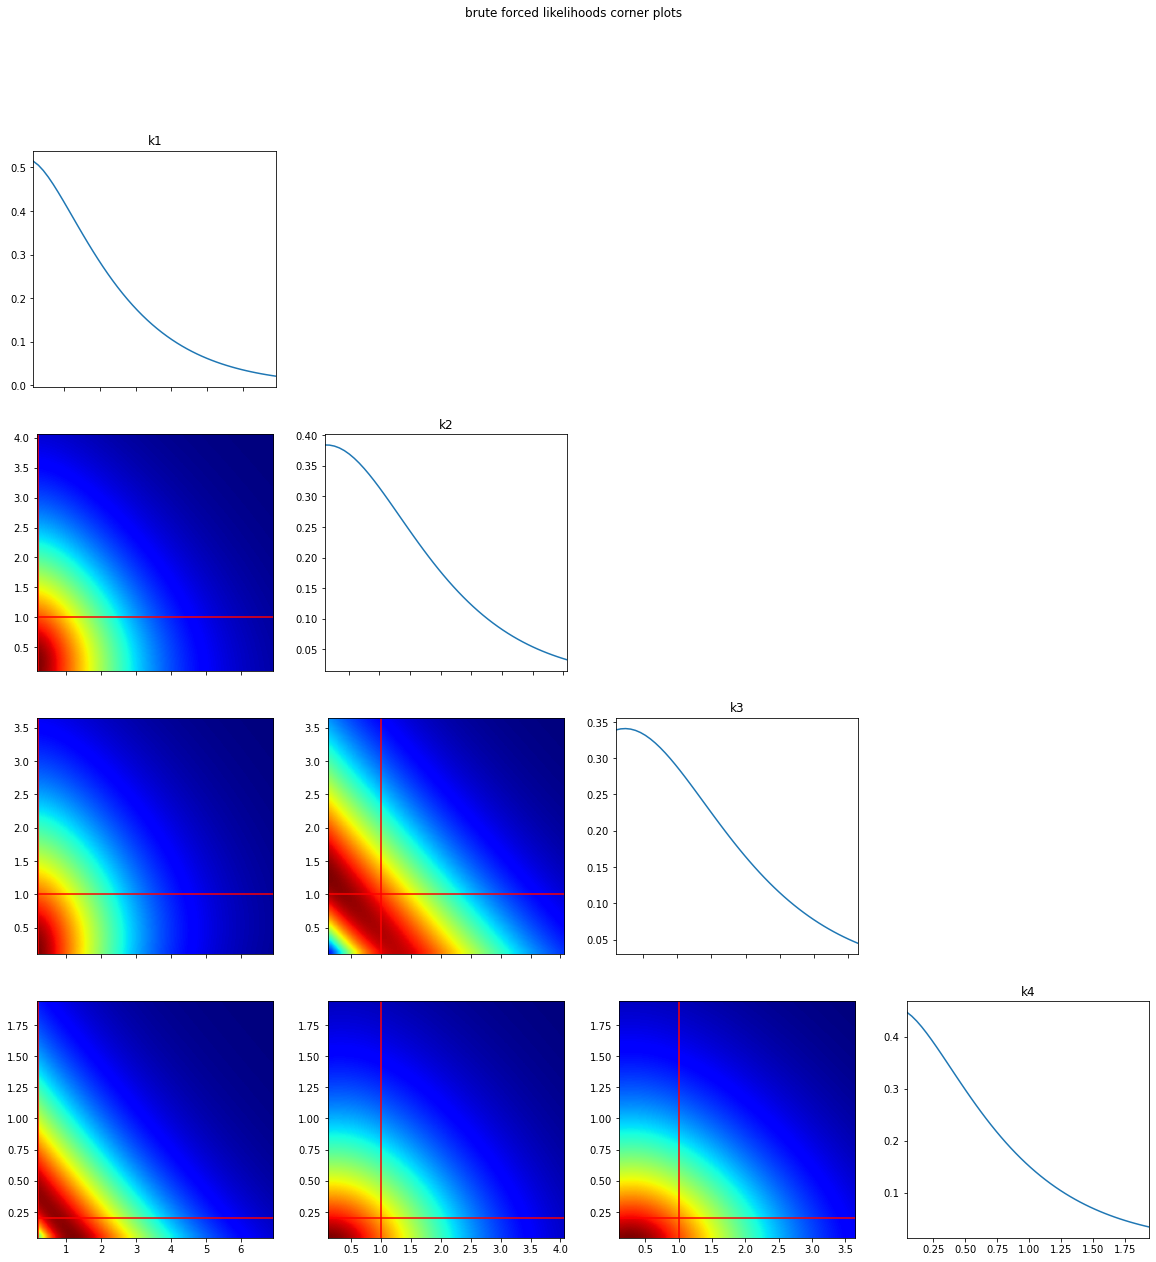

In [56]:
fig, axes = plt.subplots(4,4,figsize=(20,20),sharex='col')
for i in range(4):
    for j in range(4):
        ax = axes[i,j]
        if i == j:
            mean_axis = tuple([k for k in range(4) if k != i])
            ax.plot(grids[i], np.mean(likelihoods_grid,axis=mean_axis))
            ax.title.set_text('k' + str(i+1))
            ax.set_xlim(min(grids[i]),max(grids[i]))
        if i < j:
            ax.axis('off')
        if i > j:
            mean_axis = tuple([k for k in range(4) if k != i and k != j])
            ax.imshow(np.mean(likelihoods_grid,axis=mean_axis).T,origin='lower',cmap='jet', 
                      extent=(grids[j][0], grids[j][-1], grids[i][0], grids[i][-1]), interpolation='gaussian')
            ax.axvline(true_state[0][j], color='r')
            ax.axhline(true_state[0][i], color='r')
            
            ax.set_aspect((grids[j][0] - grids[j][-1])/(grids[i][0] - grids[i][-1]))
fig.suptitle('brute forced likelihoods corner plots')